# Задание 2. Свертки и базовые слои 
Это задание будет являться духовным наследником первого. 
Вы уже научились делать шаги градиентного спуска и вспомнили, как устроен базовый линейный слой.
На этой неделе мы построим прототип базового фреймворка до конца (собственно, многое вы сможете скопировать, если захотите). 
Хоть вы уже и знаете о torch.nn, для выполнения задания его использовать нельзя. 
Однако все элементы, которые вы будете реализовывать, достаточно просты.

In [49]:
import random
import torch
from PIL import Image
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

## Задача 1. (2 балла)
Реализуйте слой BatchNorm (nn.BatchNorm). 

In [50]:
class BatchNorm1d:
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum

        # параметры
        self.gamma = torch.ones(num_features, requires_grad=True)
        self.beta = torch.zeros(num_features, requires_grad=True)

        # скользящие статистики
        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)

        # промежуточные значения для backward
        self.cache = None

        self.training = True

        # градиенты параметров
        self.grad_gamma = torch.zeros_like(self.gamma)
        self.grad_beta = torch.zeros_like(self.beta)

    def train(self):
        self.training = True

    def eval(self):
        self.training = False

    def forward(self, x):
        """
        x: (batch_size, num_features)
        """

        if self.training:
            batch_mean = x.mean(dim=0)
            batch_var = x.var(dim=0, unbiased=False)

            # нормализация
            x_hat = (x - batch_mean) / torch.sqrt(batch_var + self.eps)

            # обновление статистик
            self.running_mean = (
                (1 - self.momentum) * self.running_mean + self.momentum * batch_mean
            )
            self.running_var = (
                (1 - self.momentum) * self.running_var + self.momentum * batch_var
            )
            out = self.gamma * x_hat + self.beta
            self.cache = (x, x_hat, batch_mean, batch_var)

        else:
            x_hat = (x - self.running_mean) / torch.sqrt(self.running_var + self.eps)
            out = self.gamma * x_hat + self.beta
            self.cache = None 

        return out

    def backward(self, dout):
        """
        dout: (batch_size, num_features)
        """

        assert self.cache is not None, "Backward нельзя вызвать в режиме eval()"

        x, x_hat, mean, var = self.cache
        N = x.shape[0]

        # градиенты по gamma и beta
        self.grad_gamma = torch.sum(dout * x_hat, dim=0)
        self.grad_beta = torch.sum(dout, dim=0)

        # градиент по x
        dx_hat = dout * self.gamma

        std_inv = 1.0 / torch.sqrt(var + self.eps)

        # формулы взяты из классического вывода BN backward
        dvar = torch.sum(dx_hat * (x - mean) * -0.5 * std_inv**3, dim=0)
        dmean = torch.sum(-dx_hat * std_inv, dim=0) + dvar * torch.mean(-2.0 * (x - mean), dim=0)

        dx = dx_hat * std_inv + dvar * 2 * (x - mean) / N + dmean / N

        return dx

    def parameters(self):
        return [self.gamma, self.beta]

    def gradients(self):
        return [self.grad_gamma, self.grad_beta]


## Задача 2. (2 балла)
Реализуйте слой Linear (nn.Linear). 

In [51]:
class Linear:
    def __init__(self, in_features, out_features):
        """
        Простой полносвязный слой

        Args:
            in_features (int): размер входного вектора
            out_features (int): размер выхода слоя
        """
        self.in_features = in_features
        self.out_features = out_features

        # инициализация весов Kaiming-like 
        limit = 1.0 / (in_features ** 0.5)
        self.W = torch.empty(out_features, in_features).uniform_(-limit, limit)
        self.b = torch.zeros(out_features)

        self.W.requires_grad = True
        self.b.requires_grad = True
        self.x_cache = None

        self.grad_W = torch.zeros_like(self.W)
        self.grad_b = torch.zeros_like(self.b)

    def forward(self, x):
        """
        x: (batch_size, in_features)
        return: (batch_size, out_features)
        """
        self.x_cache = x
        return x @ self.W.T + self.b

    def backward(self, dout):
        """
        dout: (batch_size, out_features)
        return dx: (batch_size, in_features)
        """
        x = self.x_cache

        # dL/dW = dout^T · x
        self.grad_W = dout.T @ x

        # dL/db = сумма по batch
        self.grad_b = dout.sum(dim=0)

        # dL/dx = dout · W
        dx = dout @ self.W

        return dx

    def parameters(self):
        return [self.W, self.b]

    def gradients(self):
        return [self.grad_W, self.grad_b]

## Задача 3. (2 балла)
Реализуйте слой Dropout(nn.Dropout)

In [52]:
class Dropout:
    def __init__(self, p=0.5):
        """
        Args:
            p (float): вероятность зануления нейронов
        """

        assert 0.0 <= p < 1.0, "p должно быть в диапазоне [0, 1)"
        self.p = p
        self.training = True
        self.mask = None

    def train(self):
        self.training = True

    def eval(self):
        self.training = False
        self.mask = None  # маска не нужна в eval

    def forward(self, x):
        """
        x: Tensor любого размера.
        Возвращает x после применения dropout.
        """
        if not self.training or self.p == 0.0:
            return x

        # маска Бернулли (1 — оставить, 0 — выбросить)
        # масштабирование: 1/(1-p)
        keep_prob = 1.0 - self.p
        self.mask = (torch.rand_like(x) < keep_prob).float()

        out = x * self.mask / keep_prob
        return out

    def backward(self, dout):
        """
        dout: градиент от следующего слоя
        """
        if not self.training or self.p == 0.0:
            return dout

        keep_prob = 1.0 - self.p
        dx = dout * self.mask / keep_prob
        return dx

    def parameters(self):
        return []

    def gradients(self):
        return []


## Задача 4. {*} (2 балла, 1 за каждый следующий за слой)
Реализуйте одно или более из:
  - слой ReLU(nn.ReLU)
  - слой Sigmoid(nn.Sigmoid)
  - слой Softmax(nn.Softmax)

### 4.1. ReLU

In [53]:
class ReLU:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x > 0).float()
        return x * self.mask

    def backward(self, dout):
        return dout * self.mask

    def parameters(self):
        return []

    def gradients(self):
        return []


In [54]:
def test_relu():
    relu = ReLU()

    # ----- 1. forward: корректность -----
    x = torch.tensor([[-1., 0., 3., -5., 2.]])
    out = relu.forward(x)
    expected = torch.tensor([[0., 0., 3., 0., 2.]])
    assert torch.allclose(out, expected), "ReLU forward неверен"

    # ----- 2. backward: корректность -----
    dout = torch.ones_like(out)
    dx = relu.backward(dout)
    expected_dx = torch.tensor([[0., 0., 1., 0., 1.]])
    assert torch.allclose(dx, expected_dx), "ReLU backward неверен"

    # ----- 3. граничные случаи -----
    x_edge = torch.tensor([[0., -0., 1e-12, -1e-12]])
    out_edge = relu.forward(x_edge)
    dx_edge = relu.backward(torch.ones_like(x_edge))
    expected_edge = torch.tensor([[0., 0., 1., 0.]])
    assert torch.allclose(dx_edge, expected_edge), "ReLU edge-case неверен"

    # ----- 4. сравнение с torch.nn.ReLU -----
    relu_pt = torch.nn.ReLU()
    assert torch.allclose(out_edge, relu_pt(x_edge)), "ReLU не совпадает с torch.nn"

    print("RELU: all cases are done")


test_relu()

RELU: all cases are done


### 4.2. Sigmoid

In [55]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        self.out = 1.0 / (1.0 + torch.exp(-x))
        return self.out

    def backward(self, dout):
        dx = dout * self.out * (1.0 - self.out)
        return dx

    def parameters(self):
        return []

    def gradients(self):
        return []


In [56]:
def test_sigmoid():
    sig = Sigmoid()

    # ----- 1. forward -----
    x = torch.tensor([[0., 2., -2.]])
    out = sig.forward(x)
    expected = 1 / (1 + torch.exp(-x))
    assert torch.allclose(out, expected, atol=1e-6), "Sigmoid forward неверен"

    # ----- 2. backward -----
    dout = torch.ones_like(out)
    dx = sig.backward(dout)
    expected_dx = expected * (1 - expected)
    assert torch.allclose(dx, expected_dx, atol=1e-6), "Sigmoid backward неверен"

    # ----- 3. граничные случаи -----
    x = torch.tensor([[-50., 0., 50.]])  # насыщение
    out = sig.forward(x)
    assert torch.isfinite(out).all(), "Sigmoid выдаёт инф/NaN"

    # ----- 4. сравнение с torch.nn.Sigmoid -----
    sig_pt = torch.nn.Sigmoid()
    assert torch.allclose(sig_pt(x), sig.forward(x), atol=1e-6), "Sigmoid != torch.nn"

    print("Sigmoid: all cases are done")

test_sigmoid()

Sigmoid: all cases are done


### 4.3. Softmax

In [57]:
class Softmax:
    def __init__(self, dim=-1):
        self.dim = dim
        self.out = None

    def forward(self, x):
        x_shift = x - x.max(dim=self.dim, keepdim=True).values
        exp_x = torch.exp(x_shift)
        self.out = exp_x / exp_x.sum(dim=self.dim, keepdim=True)
        return self.out

    def backward(self, dout):
        y = self.out
        sum_over = torch.sum(dout * y, dim=self.dim, keepdim=True)
        dx = y * (dout - sum_over)
        return dx

    def parameters(self):
        return []

    def gradients(self):
        return []


In [58]:
def test_softmax():
    sm = Softmax(dim=-1)

    # ----- 1. forward -----
    x = torch.tensor([[1., 2., 3.]])
    out = sm.forward(x)
    expected = torch.softmax(x, dim=-1)
    assert torch.allclose(out, expected, atol=1e-6), "Softmax forward неверен"

    # ----- 2. backward -----
    dout = torch.tensor([[1., 0., -1.]])
    dx = sm.backward(dout)

    y = expected
    manual = y * (dout - torch.sum(dout * y))
    assert torch.allclose(dx, manual, atol=1e-6), "Softmax backward неверен"

    # ----- 3. граничные случаи -----
    huge = torch.tensor([[10000., 10001., 10002.]])
    out = sm.forward(huge)
    assert torch.isfinite(out).all(), "Softmax не стабилен численно"

    # ----- 4. сравнение с torch.nn.Softmax -----
    sm_pt = torch.nn.Softmax(dim=-1)
    assert torch.allclose(
        sm_pt(huge), sm.forward(huge), atol=1e-6
    ), "Softmax != torch.nn"

    print("Softmax: all cases are done")
    
test_softmax()

Softmax: all cases are done


# Задание 2. {*} 3 балла
Реализуйте медианный фильтр. 
Для текущего пикселя, пиксели, которые «попадают» в матрицу, 
сортируются, и выбирается медианное значение из отсортированного массива. 
Это значение и является выходным для текущего пикселя.
Используйте только чистый torch. Покажите результат на примере для размера ядра 3, 5, 10


In [59]:
def median_filter_2d(x, k: int):
    """
    Медианный фильтр размера k×k для 2D тензора.
    x: Tensor (H, W)
    k: int - размер ядра
    """
    pad = k // 2
    
    # паддинг
    x_pad = torch.nn.functional.pad(x.unsqueeze(0).unsqueeze(0), (pad, pad, pad, pad), mode="reflect")

    patches = x_pad.unfold(2, k, 1).unfold(3, k, 1)
    patches = patches.contiguous().view(1, 1, x.shape[0], x.shape[1], -1)
    sorted_vals, _ = patches.sort(dim=-1)
    mid = sorted_vals[..., sorted_vals.shape[-1] // 2]

    return mid[0, 0]


In [60]:
torch.manual_seed(0)
img = torch.randint(0, 256, (10, 10)).float()

print("Original image:\n", img)

Original image:
 tensor([[172.,  47., 117., 192.,  67., 251., 195., 103.,   9., 211.],
        [ 21., 242.,  36.,  87.,  70., 216.,  88., 140.,  58., 193.],
        [230.,  39.,  87., 174.,  88.,  81., 165.,  25.,  77.,  72.],
        [  9., 148., 115., 208., 243., 197., 254.,  79., 175., 192.],
        [ 82.,  99., 216., 177., 243.,  29., 147., 147., 142., 167.],
        [ 32., 193.,   9., 185., 127.,  32.,  31., 202., 244., 151.],
        [163., 254., 203., 114., 183.,  28.,  34., 128., 128., 164.],
        [ 53., 133.,  38., 232., 244.,  17.,  79., 132., 105.,  42.],
        [186.,  31., 120.,   1.,  65., 231., 169.,  57.,  35., 102.],
        [119.,  11., 174.,  82.,  91., 128., 142.,  99.,  53., 140.]])


In [61]:
img_3 = median_filter_2d(img, 3)
img_5 = median_filter_2d(img, 5)
img_10 = median_filter_2d(img, 10)

print("\nmedian_filter 3×3:\n", img_3)
print("\nmedian_filter 5×5:\n", img_5)
print("\nmedian_filter 10×10:\n", img_10)


median_filter 3×3:
 tensor([[172.,  47.,  87.,  70.,  87.,  88., 140.,  88., 140.,  58.],
        [ 47.,  87.,  87.,  87.,  88.,  88., 140.,  88.,  77.,  72.],
        [148.,  87., 115.,  88., 174., 165., 140.,  88.,  79.,  77.],
        [ 99.,  99., 148., 177., 177., 165., 147., 147., 142., 142.],
        [ 99.,  99., 177., 185., 185., 147., 147., 147., 167., 175.],
        [163., 163., 185., 183., 127.,  34.,  34., 142., 151., 151.],
        [163., 133., 185., 183., 127.,  34.,  34., 128., 132., 128.],
        [133., 133., 120., 120., 114.,  79.,  79., 105., 105., 105.],
        [ 53., 119.,  82.,  91.,  91., 128., 128.,  99.,  99.,  53.],
        [ 31., 120.,  31.,  82.,  82., 142., 142.,  57.,  57.,  53.]])

median_filter 5×5:
 tensor([[ 87.,  87.,  87.,  87.,  88.,  88.,  88.,  88.,  77.,  77.],
        [ 87., 115.,  87., 115., 115., 140.,  88., 140.,  88.,  79.],
        [ 99., 115., 115., 117., 165., 147., 140., 147., 142., 103.],
        [ 99., 115., 115., 127., 127., 147., 14

# Задание 3. 6 баллов
Реализуйте следующие классы (указана сигнатура __init__):
- BaseTransform(p: float) [*базовый класс для всех трансформаций*]
- RandomCrop(p: float, **kwargs)
- RandomRotate(p: float, **kwargs)
- RandomZoom(p: float, **kwargs) {*}
- ToTensor() 
- Compose(list[BaseTransform])

Последний класс должен принимать на вход список инстансов трех других.
При вызове метода __call__ он должен последовательно вызывать трансформации из списка.
При вызове каждого из них с вероятностью p должно 
применяться изменение изображения, с вероятностью 1-p должно возвращаться исходное 
изображение. Класс входного изображения у всех классов - PIL.Image, выходного тоже.
Класс ToTensor должен принимать на вход PIL.Image, возвращать - torch.Tensor.

**torch.nn использовать нельзя!**

In [62]:
class BaseTransform:
    def __init__(self, p: float):
        assert 0.0 <= p <= 1.0
        self.p = p

    def __call__(self, img: Image.Image) -> Image.Image:
        if random.random() < self.p:
            return self.apply(img)
        return img

    def apply(self, img: Image.Image) -> Image.Image:
        raise NotImplementedError()

In [63]:
class RandomCrop(BaseTransform):
    def __init__(self, p: float, size: int | tuple[int, int]):
        super().__init__(p)
        if isinstance(size, int):
            self.crop_h = size
            self.crop_w = size
        else:
            self.crop_h, self.crop_w = size

    def apply(self, img: Image.Image) -> Image.Image:
        w, h = img.size

        if self.crop_w > w or self.crop_h > h:
            return img

        left = random.randint(0, w - self.crop_w)
        top = random.randint(0, h - self.crop_h)

        return img.crop((left, top, left + self.crop_w, top + self.crop_h))


In [64]:
class RandomRotate(BaseTransform):
    def __init__(self, p: float, degrees: float):
        super().__init__(p)
        self.degrees = degrees

    def apply(self, img: Image.Image) -> Image.Image:
        angle = random.uniform(-self.degrees, self.degrees)
        return img.rotate(angle, resample=Image.BILINEAR)


In [65]:
class RandomZoom(BaseTransform):
    def __init__(self, p: float, min_zoom: float, max_zoom: float):
        """
        min_zoom < 1 → уменьшение
        max_zoom > 1 → увеличение
        """
        super().__init__(p)
        assert min_zoom > 0
        assert max_zoom > 0
        self.min_zoom = min_zoom
        self.max_zoom = max_zoom

    def apply(self, img: Image.Image) -> Image.Image:
        zoom = random.uniform(self.min_zoom, self.max_zoom)

        w, h = img.size
        new_w = int(w * zoom)
        new_h = int(h * zoom)

        img_zoomed = img.resize((new_w, new_h), resample=Image.BILINEAR)

        if zoom >= 1.0:
            left = (new_w - w) // 2
            top = (new_h - h) // 2
            return img_zoomed.crop((left, top, left + w, top + h))

        else:
            canvas = Image.new("RGB", (w, h))
            left = (w - new_w) // 2
            top = (h - new_h) // 2
            canvas.paste(img_zoomed, (left, top))
            return canvas

In [66]:
class ToTensor:
    def __init__(self, size=(28, 28)):
        self.size = size  # (width, height)

    def __call__(self, img: Image.Image) -> torch.Tensor:

        if img.size != self.size:
            img = img.resize(self.size, Image.BILINEAR)

        arr = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes()))
        w, h = img.size
        c = len(img.getbands())
        arr = arr.view(h, w, c)
        arr = arr.permute(2, 0, 1).float() / 255.0

        return arr


In [67]:
class Compose:
    def __init__(self, transforms: list[BaseTransform]):
        self.transforms = transforms

    def __call__(self, img: Image.Image):
        for t in self.transforms:
            img = t(img)
        return img

# Задание 4. 3 балла
Примените трансформации из задания 3 в качестве трансформаций датасета из практики 2.2.
**В этом задании можно пользоваться torch.nn, за исключением трансформаций.**
Покажите, как меняются лосс и метрики на трейне и на тесте в зависимости от количества и вероятностей трансформаций.
Проведите обучение на большом количестве эпох. 
Опишите, что вы наблюдаете для каждого случая и какая есть разница,
если применить трансформации.
Предоставьте графики в matplotlib или tensorboard (+1 балл) в 
ноутбуке (в случае с tensorboard можно в отдельном окне) с наглядными примерами

In [68]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

In [66]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: <__main__.ToTensor object at 0x00000248849CBFA0>

In [67]:
from torch import nn
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(32*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)


In [78]:
tf_none = ToTensor()

tf_light = Compose([
    RandomCrop( p=0.3, size=26 ),
    RandomRotate( p=0.3, degrees=10 ),
    ToTensor()
])

tf_strong = Compose([
    RandomCrop( p=0.6, size=24 ),
    RandomRotate( p=0.6, degrees=25 ),
    RandomZoom( p=0.5, min_zoom=0.7, max_zoom=1.3 ),
    ToTensor()
])



In [69]:
def get_loaders(transform, batch=64):
    train = datasets.FashionMNIST(
        "data", train=True, download=True, transform=transform
    )
    test = datasets.FashionMNIST(
        "data", train=False, download=True, transform=ToTensor()
    )
    return (
        DataLoader(train, batch_size=batch, shuffle=True),
        DataLoader(test, batch_size=batch)
    )


In [70]:
def train_one_epoch(model,loader,loss_fn,opt,device):
    model.train()
    total_loss=0; total_correct=0
    for x,y in loader:
        x,y=x.to(device),y.to(device)
        opt.zero_grad()
        pred=model(x)
        loss=loss_fn(pred,y)
        loss.backward()
        opt.step()
        total_loss+=loss.item()*x.size(0)
        total_correct+=(pred.argmax(dim=1)==y).sum().item()
    n=len(loader.dataset)
    return total_loss/n, total_correct/n


def eval_model(model,loader,loss_fn,device):
    model.eval()
    total_loss=0; total_correct=0
    with torch.no_grad():
        for x,y in loader:
            x,y=x.to(device),y.to(device)
            pred=model(x)
            loss=loss_fn(pred,y)
            total_loss+=loss.item()*x.size(0)
            total_correct+=(pred.argmax(dim=1)==y).sum().item()
    n=len(loader.dataset)
    return total_loss/n, total_correct/n


In [71]:
def run_experiment(name, transform, epochs=25, device="cpu"):
    train_loader, test_loader = get_loaders(transform)
    model = SimpleCNN().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    tr_losses=[]; te_losses=[]
    tr_accs=[]; te_accs=[]

    for ep in range(epochs):
        tl, ta = train_one_epoch(model, train_loader, loss_fn, opt, device)
        vl, va = eval_model(model, test_loader, loss_fn, device)

        tr_losses.append(tl); te_losses.append(vl)
        tr_accs.append(ta); te_accs.append(va)

        print(f"[{name}] epoch {ep+1}/{epochs}: "
              f"train loss {tl:.4f}, acc {ta:.4f} | "
              f"test loss {vl:.4f}, acc {va:.4f}")

    return dict(
        tr_loss=tr_losses, te_loss=te_losses,
        tr_acc=tr_accs, te_acc=te_accs
    )


In [45]:
device="cuda" if torch.cuda.is_available() else "cpu"
res_none = run_experiment("none", tf_none, 20, device)



[none] epoch 1/20: train loss 0.5158, acc 0.8149 | test loss 0.4058, acc 0.8507
[none] epoch 2/20: train loss 0.3323, acc 0.8804 | test loss 0.3106, acc 0.8859
[none] epoch 3/20: train loss 0.2818, acc 0.8982 | test loss 0.3055, acc 0.8874
[none] epoch 4/20: train loss 0.2531, acc 0.9068 | test loss 0.2673, acc 0.9014
[none] epoch 5/20: train loss 0.2315, acc 0.9157 | test loss 0.2635, acc 0.9032
[none] epoch 6/20: train loss 0.2129, acc 0.9208 | test loss 0.2561, acc 0.9077
[none] epoch 7/20: train loss 0.1952, acc 0.9264 | test loss 0.2472, acc 0.9111
[none] epoch 8/20: train loss 0.1799, acc 0.9331 | test loss 0.2449, acc 0.9113
[none] epoch 9/20: train loss 0.1645, acc 0.9377 | test loss 0.2438, acc 0.9123
[none] epoch 10/20: train loss 0.1542, acc 0.9419 | test loss 0.2654, acc 0.9121
[none] epoch 11/20: train loss 0.1386, acc 0.9485 | test loss 0.2515, acc 0.9139
[none] epoch 12/20: train loss 0.1262, acc 0.9520 | test loss 0.2592, acc 0.9119
[none] epoch 13/20: train loss 0.1166

In [73]:
res_light = run_experiment("light", tf_light, 20, device)

[light] epoch 1/20: train loss 0.5797, acc 0.7857 | test loss 0.4105, acc 0.8492
[light] epoch 2/20: train loss 0.3932, acc 0.8567 | test loss 0.3516, acc 0.8766
[light] epoch 3/20: train loss 0.3440, acc 0.8738 | test loss 0.3146, acc 0.8886
[light] epoch 4/20: train loss 0.3131, acc 0.8827 | test loss 0.3070, acc 0.8871
[light] epoch 5/20: train loss 0.2920, acc 0.8912 | test loss 0.3088, acc 0.8882
[light] epoch 6/20: train loss 0.2718, acc 0.8984 | test loss 0.3088, acc 0.8884
[light] epoch 7/20: train loss 0.2592, acc 0.9033 | test loss 0.2604, acc 0.9058
[light] epoch 8/20: train loss 0.2452, acc 0.9087 | test loss 0.2707, acc 0.9038
[light] epoch 9/20: train loss 0.2359, acc 0.9110 | test loss 0.2430, acc 0.9135
[light] epoch 10/20: train loss 0.2251, acc 0.9163 | test loss 0.2438, acc 0.9162
[light] epoch 11/20: train loss 0.2145, acc 0.9201 | test loss 0.2341, acc 0.9165
[light] epoch 12/20: train loss 0.2076, acc 0.9222 | test loss 0.2413, acc 0.9160
[light] epoch 13/20: trai

In [79]:
res_strong = run_experiment("strong", tf_strong, 20, device)

[strong] epoch 1/20: train loss 0.8094, acc 0.6924 | test loss 0.5150, acc 0.8041
[strong] epoch 2/20: train loss 0.5929, acc 0.7726 | test loss 0.4502, acc 0.8363
[strong] epoch 3/20: train loss 0.5369, acc 0.7943 | test loss 0.4133, acc 0.8491
[strong] epoch 4/20: train loss 0.5037, acc 0.8065 | test loss 0.3786, acc 0.8668
[strong] epoch 5/20: train loss 0.4730, acc 0.8193 | test loss 0.3612, acc 0.8693
[strong] epoch 6/20: train loss 0.4543, acc 0.8258 | test loss 0.3403, acc 0.8748
[strong] epoch 7/20: train loss 0.4399, acc 0.8319 | test loss 0.3239, acc 0.8835
[strong] epoch 8/20: train loss 0.4253, acc 0.8374 | test loss 0.3188, acc 0.8851
[strong] epoch 9/20: train loss 0.4146, acc 0.8427 | test loss 0.3162, acc 0.8865
[strong] epoch 10/20: train loss 0.4037, acc 0.8458 | test loss 0.2968, acc 0.8933
[strong] epoch 11/20: train loss 0.3951, acc 0.8502 | test loss 0.3139, acc 0.8877
[strong] epoch 12/20: train loss 0.3858, acc 0.8534 | test loss 0.3192, acc 0.8837
[strong] epoc

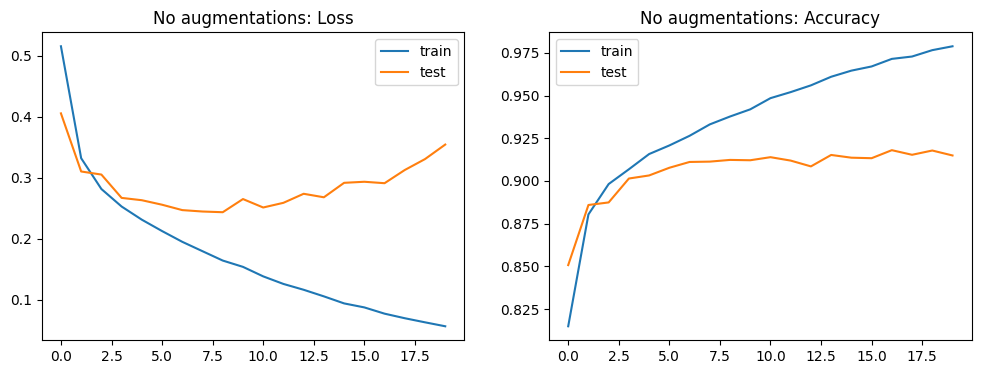

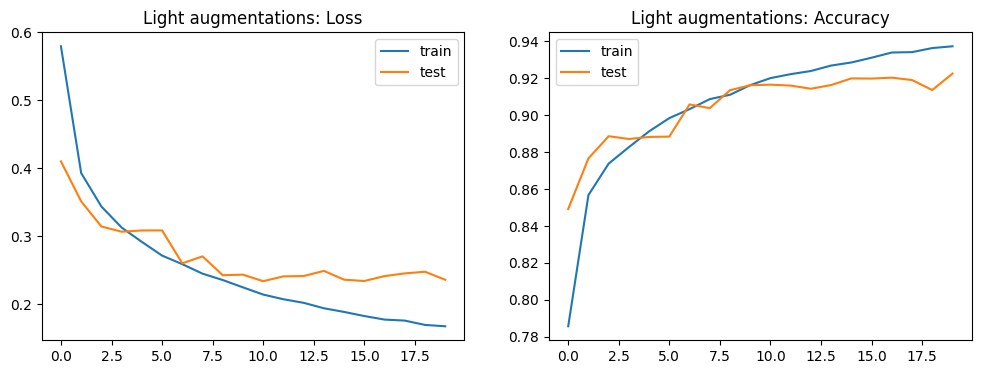

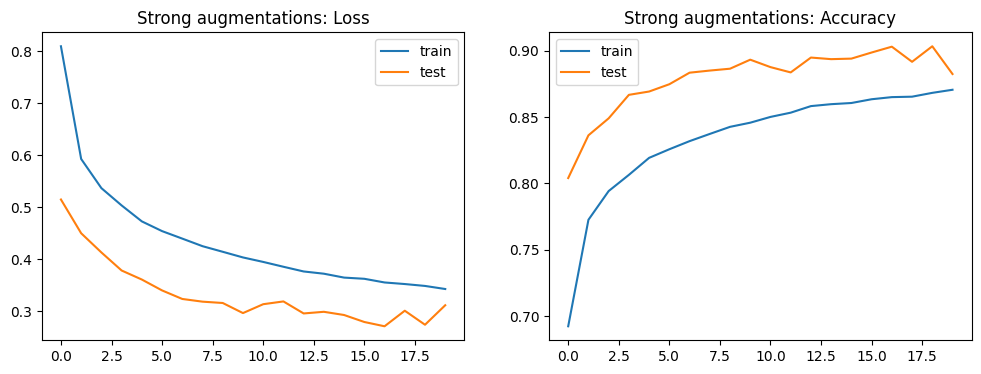

In [82]:
def plot_results(res, name):
    plt.figure(figsize=(12,4))
    
    # Loss
    plt.subplot(1,2,1)
    plt.plot(res["tr_loss"], label="train")
    plt.plot(res["te_loss"], label="test")
    plt.title(f"{name}: Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(res["tr_acc"], label="train")
    plt.plot(res["te_acc"], label="test")
    plt.title(f"{name}: Accuracy")
    plt.legend()

    plt.show()


plot_results(res_none, "No augmentations")
plot_results(res_light, "Light augmentations")
plot_results(res_strong, "Strong augmentations")


По графикам видно, что без аугментаций модель быстро переобучается: train-лосс стремится к нулю и accuracy ≈ 0.98, тогда как test-лосс начинает расти, а точность застревает около 0.91–0.92. Лёгкие аугментации дают лучший баланс: train-качество немного ниже, но test-лосс меньше, кривые train/test ближе друг к другу, а тестовая точность максимальна — модель обобщает лучше. При сильных аугментациях переобучения нет, но сеть уже недообучается: train-accuracy заметно падает, а test-accuracy получается чуть хуже, чем при умеренных преобразованиях.